In [6]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#augmentation the train and test data for model to avoid the overfitting and normalize the directories



In [9]:
# Define constants
image_size = (224, 224)  # Rescale images to 224x224 pixels
batch_size = 32

# Define paths to the original training and test directories
train_dir = '/content/drive/MyDrive/archive/train'
test_dir = '/content/drive/MyDrive/archive/test'

# Get the list of subdirectories in the original training directory
subdirectories = os.listdir(train_dir)

# Split the subdirectories into training and validation sets
train_subdirs, validation_subdirs = train_test_split(subdirectories, test_size=0.3, random_state=42)

# Create directories for training and validation data
train_data_dir = 'path/to/train_data'
os.makedirs(train_data_dir, exist_ok=True)

validation_data_dir = 'path/to/validation_data'
os.makedirs(validation_data_dir, exist_ok=True)

# Move images to the corresponding directories
for subdir in subdirectories:
    filenames = os.listdir(os.path.join(train_dir, subdir))
    train_filenames, validation_filenames = train_test_split(filenames, test_size=0.3, random_state=42)

    for filename in train_filenames:
        src = os.path.join(train_dir, subdir, filename)
        dst = os.path.join(train_data_dir, subdir, filename)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for filename in validation_filenames:
        src = os.path.join(train_dir, subdir, filename)
        dst = os.path.join(validation_data_dir, subdir, filename)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

# Define data generators with augmentation for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Print the number of samples in each class for training and validation
print("Number of samples in training set:")
print(train_generator.classes)
print("\nNumber of samples in validation set:")
print(validation_generator.classes)

# Evaluate the model
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 8385 images belonging to 2 classes.
Found 3594 images belonging to 2 classes.
Number of samples in training set:
[0 0 0 ... 1 1 1]

Number of samples in validation set:
[0 0 0 ... 1 1 1]
Found 2020 images belonging to 2 classes.


#show the images in the train directory:

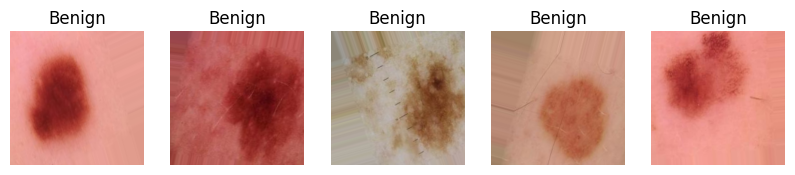

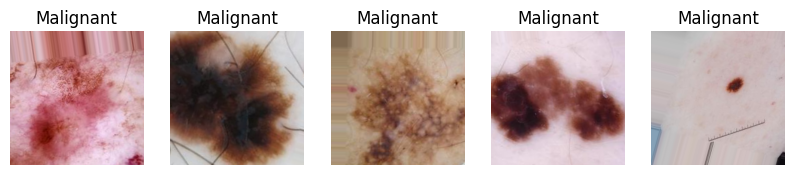

In [4]:
# Define the number of images to plot from each class
num_images_per_class = 5

# Get class indices
class_indices = train_generator.class_indices

# Inverse mapping of class indices to class labels
class_labels = {v: k for k, v in class_indices.items()}

# Plot images from each class
for class_index, class_label in class_labels.items():
    # Find the first num_images_per_class images belonging to the current class
    class_images = [image for image, label in zip(train_generator[0][0], train_generator[0][1]) if label[class_index] == 1][:num_images_per_class]

    # Plot the images
    plt.figure(figsize=(10, 5))
    for i, image in enumerate(class_images):
        plt.subplot(1, num_images_per_class, i + 1)
        plt.imshow(image)
        plt.title(class_label)
        plt.axis('off')
    plt.show()

#show the images in the test directory:

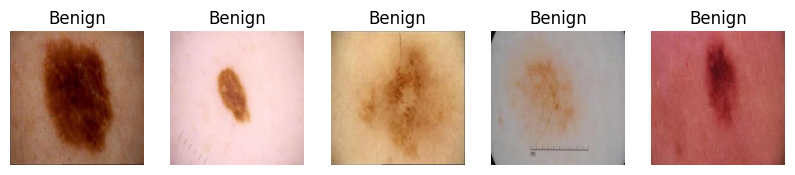

<Figure size 1000x500 with 0 Axes>

In [5]:
# Define the number of images to plot from each class
num_images_per_class = 5

# Get class indices
class_indices = test_generator.class_indices

class_labels = {v: k for k, v in class_indices.items()}

# Plot images from each class
for class_index, class_label in class_labels.items():
    # Find the first num_images_per_class images belonging to the current class
    class_images = [image for image, label in zip(test_generator[0][0], test_generator[0][1]) if label[class_index] == 1][:num_images_per_class]

    # Plot the images
    plt.figure(figsize=(10, 5))
    for i, image in enumerate(class_images):
        plt.subplot(1, num_images_per_class, i + 1)
        plt.imshow(image)
        plt.title(class_label)
        plt.axis('off')
    plt.show()

#build the model:

In [6]:
# Define the input shape
input_shape = (224, 224, 3)

# Load the DenseNet201 base model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape, pooling=None)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Define a sequential model that uses the base model
model = models.Sequential()

# Add the base model as the first layer
model.add(base_model)

# Add three convolutional layers with padding
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), padding='same'))  # Add padding here

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), padding='same'))  # Add padding here

model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), padding='same'))  # Add padding here

# Add global average pooling layer
model.add(layers.GlobalAveragePooling2D())

# Add dense layers with regularization and dropout
model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(layers.Dropout(0.5))

# Add output layer with L2 regularization
output_layer = layers.Dense(2, activation='softmax', kernel_regularizer=l2(0.001))
model.add(output_layer)

# Compile the model with the specified optimizer and loss function
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


74836368/74836368 [==============================] - 0s 0us/step


#train the model:

Epoch 1/10
263/263 [==============================] - 176s 579ms/step - loss: 0.9550 - accuracy: 0.7185 - val_loss: 0.5852 - val_accuracy: 0.8216
Epoch 2/10
263/263 [==============================] - 141s 536ms/step - loss: 0.7385 - accuracy: 0.7870 - val_loss: 0.5774 - val_accuracy: 0.8350
Epoch 3/10
263/263 [==============================] - 145s 550ms/step - loss: 0.6785 - accuracy: 0.7989 - val_loss: 0.5494 - val_accuracy: 0.8503
Epoch 4/10
263/263 [==============================] - 135s 515ms/step - loss: 0.6105 - accuracy: 0.8150 - val_loss: 0.5322 - val_accuracy: 0.8520
Epoch 5/10
263/263 [==============================] - 137s 522ms/step - loss: 0.5806 - accuracy: 0.8301 - val_loss: 0.5178 - val_accuracy: 0.8573
Epoch 6/10
263/263 [==============================] - 132s 503ms/step - loss: 0.5755 - accuracy: 0.8273 - val_loss: 0.5058 - val_accuracy: 0.8559
Epoch 7/10
263/263 [==============================] - 135s 513ms/step - loss: 0.5487 - accuracy: 0.8426 - val_loss: 0.4962 -

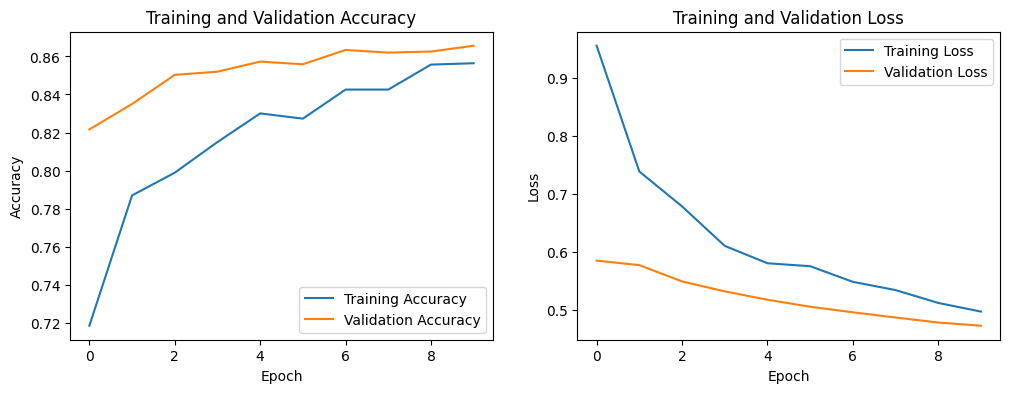

In [7]:
# Define the number of epochs
num_epochs = 10

# Train the model
history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
    verbose=1
)

model.save('/content/drive/MyDrive/saved_model/my_model')

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


In [10]:
# Load the saved model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/my_model')

# Evaluate the model on the test dataset
test_loss, test_accuracy = loaded_model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)



64/64 [==============================] - 504s 8s/step - loss: 0.4696 - accuracy: 0.8668
Test Loss: 0.4696390628814697
Test Accuracy: 0.8668316602706909


64/64 [==============================] - 14s 166ms/step


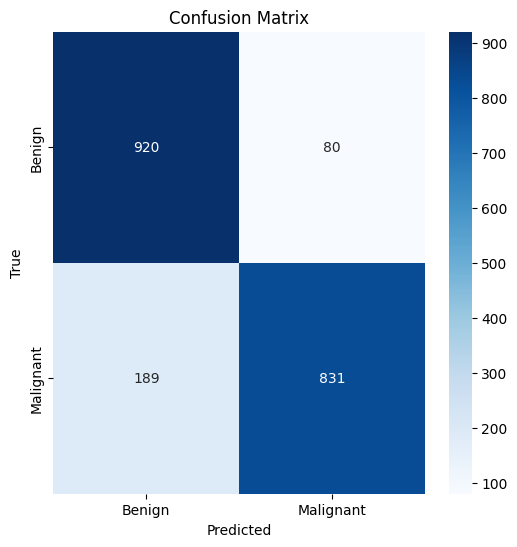

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np


# Make predictions on the test set
predictions = loaded_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

1/1 [==============================] - 10s 10s/step


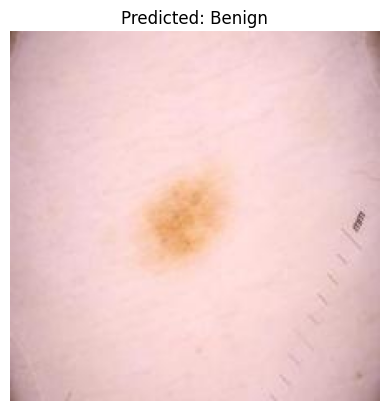

In [15]:
# Test the model on a single image:
def test_single_image(image_path,model):
    img = load_img(image_path, target_size=image_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction[0])
    predicted_label = class_labels[predicted_class]

    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Example usage:
single_image_path = '/content/drive/MyDrive/archive/test/Benign/7282.jpg'
test_single_image(single_image_path,loaded_model)